<font size="6"><center><b>Fundamentos de *Deep Learning*</b></center></font>

<font size="4"><center><b>Redes Neurais Multicamadas</b></center></font>
  
<font size="3"><center>Prof. Dr. Renato Moraes Silva</center></font>
<br/>

# <center>Redes neurais multicamadas usando TensorFlow</center>
*
Neste tutorial, iremos implementar uma rede neural multicamadas (MLP, do inglês, *multilayer* Perceptron) que usa o algoritmo *backpropagation*. Ela será aplicada na tarefa de reconhecimento de dígitos manuscritos (Figura 1). Para isso, usaremos a API Keras da biblioteca TensorFlow.

<center>
<div style="padding: 0px; float: center;">
    <img src="figs/digitos.png"  style="height:400px;"/>
    <center><em>Figura 1. Amostras do conjunto de dados.</em></center>
</div>
</center>

O conjunto que você utilizará será de digitos manuscritos. Cada imagem tem dimensão de 28 x 28 pixels e cada pixel é representado por um valor inteiro com a intensidade do tom de cinza naquela região.

O conjunto de dados contém 5.000 amostras dos dígitos de 0 a 9.

---
## Carregando e visualizando os dados


Primeiro, vamos carregar os dados do arquivo.

In [1]:
# -*- coding: utf-8 -*-
import numpy as np  # importa a biblioteca usada para trabalhar com vetores e matrizes
import pandas as pd # importa a biblioteca usada para trabalhar com dataframes (dados em formato de tabela) e análise de dados
import os # importa a biblioteca para tarefas relacionadas ao sistema operacional
import cv2

from zipfile import ZipFile # biblioteca para arquivoz zipados

def importDataset(path):
    # percorre as pastas e coleta as imagens
    labelList = []
    imgList = []

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # 1) Percorra as 10 pastas de imagens
    # 2) Use o método listdir da biblioteca os para listar todos os arquivos em cada pasta
    # 3) Use a biblioteca OpenCV para abrir cada imagem
    # 4) adicione as imagem na lista imgList
    # 5) adicione as classes (nome da pasta) na lista labelList

    for i in range(0,10):

        print("Folder: %d" %i)

        # coleta os nomes dos arquivos da pasta
        files = os.listdir(path + str(i) )

        for file in files:

            # abre a imagem
            img = cv2.imread(path + str(i) + '/' + file, cv2.IMREAD_GRAYSCALE)

            imgList.append(img)

            # guarda a classe da imagem
            labelList.append(i)

    return imgList, labelList

# extrai os arquivos
z = ZipFile('dados/MNIST.zip', 'r')
z.extractall('dados/')
z.close()

# Caminho dos arquivos
path = "dados/MNIST/"

imgList, labelList = importDataset(path)

print('\nQuantidade de imagens: ', len(imgList))

imgList[0].shape

Folder: 0
Folder: 1
Folder: 2
Folder: 3
Folder: 4
Folder: 5
Folder: 6
Folder: 7
Folder: 8
Folder: 9

Quantidade de imagens:  5000


(28, 28)

As imagens e as classes foram guardadas em uma lista. Você deve converter as imagens em uma matriz, onde cada linha representará uma imagem. Converta também a lista de classes em um vetor.

In [2]:
# variável que deverá recer as imagens
X_img = None

# variável que irá receber as classes
Y = None

########################## COMPLETE O CÓDIGO AQUI  ########################
#
# (1) percorra todas as imagens da lista e converta em um vetor usando
#     a função ravel do numpy
#
# (2) converta a lista em um array usando a função asarray do numpy e guarde na variável X
#

for i, img in enumerate(imgList):
    imgList[i] = np.ravel( imgList[i] )

X_img = np.asarray( imgList )
Y = np.asarray( labelList )

##########################################################################

print('\nDimensao de X: ', X_img.shape)

print('\nDimensao de Y: ', Y.shape)

print('\nClasses do problema: ', np.unique(Y))


Dimensao de X:  (5000, 784)

Dimensao de Y:  (5000,)

Classes do problema:  [0 1 2 3 4 5 6 7 8 9]


Os tons de cinza são representados por valores entre 0 e 255. Esse formato de valores não é adequado para métodos de classificação baseados em otimização. Por isso, você deve normalizar esses valores para o intervalo entre 0 e 1. Para isso, basta dividir por 255.

In [3]:
# variável que deverá recer as imagens normalizadas
X = None

########################## COMPLETE O CÓDIGO AQUI  ########################
# (1) normalize os pixels para um intervalo entre 0 e 1, dividindo por 255
#
# Obs: cuidado porque os valores são inteiros. Divisão de dois inteiros
#      resulta em um novo inteiro

X = X_img/255.0

##########################################################################

print('Maior valor de X: %1.10f' %np.max(X) )
print('Menor valor de X: %1.10f' %np.min(X) )

Maior valor de X: 1.0000000000
Menor valor de X: 0.0000000000


Vamos plotar aleatoriamente 100 amostras da base de dados.

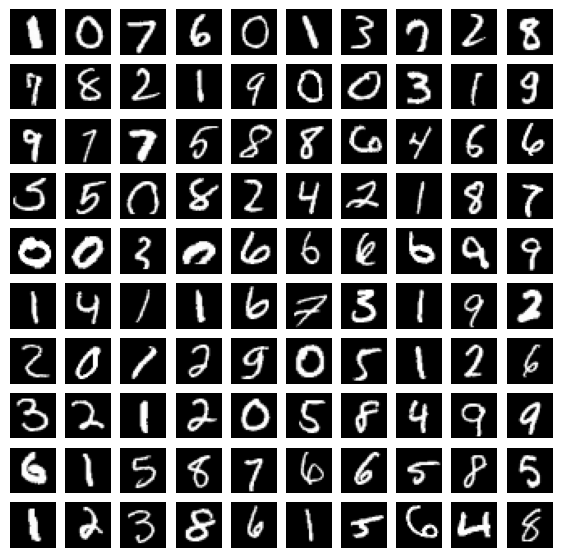

In [4]:
import matplotlib.pyplot as plt

def visualizaDados(X):

    # Calcula numero de linhas e colunas
    m, n = X.shape

    # calcula a largura das imagens
    example_width = int(round(np.sqrt(n)) )
    example_height = int(n / example_width)

    # Calcula numero de itens que serao exibidos
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, axs = plt.subplots(display_rows,display_cols, figsize=(7, 7))

    for ax, i in zip(axs.ravel(), range( X.shape[0] )):

        new_X = np.reshape( np.ravel(X[i,:]), (example_width, example_height) )

        ax.imshow(new_X, cmap='gray');
        ax.axis('off')

    plt.show()


idx_perm = np.random.permutation( range(X.shape[0]) )
visualizaDados( X[idx_perm[0:100],:] )

## Implementando a rede neural

---
Antes de implementar a rede neural, vamos separar os dados em treino (80%) e teste (20%).

In [5]:
def holdout(X, Y, porcTrain = 0.8, randomSeed = 10):

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # (1) Descubra a qtd de dados de treino multiplicando pela porcentagem
    # (2) Use o método permutation do pacote random.RandomState do numpy para
    #     embaralhar os índices
    # (3) Use os índices embaralhados para embaralhar os dados
    # (4) Separe em treino e teste

    qtdTreino = int(X.shape[0]*porcTrain)

    # embaralha os indices
    permutedIndexes = np.random.RandomState(randomSeed).permutation( X.shape[0] )

    # embaralha os dados com base nos indices embaralhados
    X_shuffled, Y_shuffled = X[permutedIndexes,:], Y[permutedIndexes]

    # separa em treino e teste
    X_train, Y_train = X_shuffled[0:qtdTreino,:], Y_shuffled[0:qtdTreino]
    X_test, Y_test = X_shuffled[qtdTreino:,:], Y_shuffled[qtdTreino:]

    ##########################################################################

    return X_train, X_test, Y_train, Y_test

# separa em treino e teste
X_train, X_test, Y_train, Y_test = holdout(X, Y, porcTrain = 0.8, randomSeed = 10)

print('Qtd. dados de treinamento: %d (%1.2f%%)' %(X_train.shape[0], (X_train.shape[0]/X.shape[0])*100) )
print('Qtd. de dados de teste: %d (%1.2f%%)' %(X_test.shape[0], (X_test.shape[0]/X.shape[0])*100) )

Qtd. dados de treinamento: 4000 (80.00%)
Qtd. de dados de teste: 1000 (20.00%)


A rede neural proposta para este exercício tem 3 camadas: uma camada de entrada, uma camada oculta e uma camada de saída. É importante lembrar que a camada de entrada possui 784 neurônios que corresponde ao total de pixels de cada imagem.

Vamos carregar os parâmetros que serão usados na arquitetura da rede neural.

In [6]:
# parametros a serem utilizados neste exercicio
input_layer_size  = 28*28  # 20x20 dimensao das imagens de entrada
hidden_layer_size = 25   # 25 neuronios na camada oculta
num_labels = 10          # 10 rotulos, de 1 a 10
                             #  (observe que a classe "0" recebe o rotulo 10)

Nós iremos usar uma a biblioteca **tensorflow**. Como o nosso problema é de classificação multiclasse, essa biblioteca exige que façamos a conversão das classes para o formato binário. Espera-se vetores com $|C|$ (onde, $|C|$ é o número de classes) posições contendo 1 para o elemento referente à classe esperada e 0 nos demais elementos. Por exemplo, seja 5 o rótulo de determinada amostra, o vetor $Y$ correspondente terá 1 na posição $y_5$ e 0 nas demais posições.

In [9]:
# converte as classes para o formato binário
def converteBinario(Y, num_labels):
    m = len(Y)

    # variavel que irá ser retornada
    Y_bin = None

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # (1) Converta em um vetor binário: 1 para o índice que representa a
    #     classe atual, enquanto atribui 0 aos demais.

    Y_bin = np.zeros([m, num_labels], dtype = int)
    for i in range(m):
        Y_bin[i, Y[i]] = 1


    ##########################################################################

    return Y_bin

# chama a funca que ira converter em binario
Y_trainBin = converteBinario(Y_train, num_labels)

print("Cinco primeiras classes: ")
print(Y_trainBin[0:5, :])

Cinco primeiras classes: 
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


Agora, vamos configurar a rede neural.

In [ ]:
# variável que deverá recer o modelo
model = None

########################## COMPLETE O CÓDIGO AQUI  ########################
#
# (1) importe o método tensorflow.keras.models.Sequential
# (2) importe o método tensorflow.keras.models.Dense
# (3) importe o método tensorflow.keras.models.Input
# (3) inicialize a camada de entrada usando o método Input
# (4) crie uma camada intermediária usando o método Dense.
#     Use ativação sigmoid. Defina a regulação com o método tf.keras.regularizers.L2
# (5) crie uma camada de saída com ativação sigmoid usando o método Dense
#     Use ativação sigmoid
# (6) inicialize o método de otimização que será usado para otimizar os
#     custos. Use o SGD: tf.keras.optimizers.SGD e defina o learning_rate
# (7) Configure o treinamento por meio do método compile.
#     Para o parâmetro loss, use o categorical_crossentropy.
#     Para o parâmetro optimizer, use o método de otimização do passo anterior.
#     Para o parâmetro metrics, use acurácia
# (8) Inicie o treinamento com o método fit. Defina o parâmetro epochs com valor
#     500. Use o parâmetro validation_split com valor 0.2. Defina o parâmetro
#     batch_size para 500. Use o parâmetro verbose como 0 para não ficar imprimindo
#     cada época na tela
import tensorflow as tf
from tensorflow import keras

input_shape = (input_layer_size,)

model = tf.keras.Sequential()

#camada de entrada
model.add(tf.keras.Input(shape = input_shape))

#camada intermediaria
model.add(tf.keras.layers.Dense(units = hidden_layer_size,
                                activation = 'sigmoid'))

#camada saida
model.add(tf.keras.layers.Dense(units = num_labels,
                                activation = 'sigmoid'))

optmizer = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(loss = 'categorical_crossentropy', optimizer=optmizer, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, Y_trainBin, epochs=500, batch_size=250, validation_split=0.2)

##########################################################################

Vamos plotar a evolução do erro.

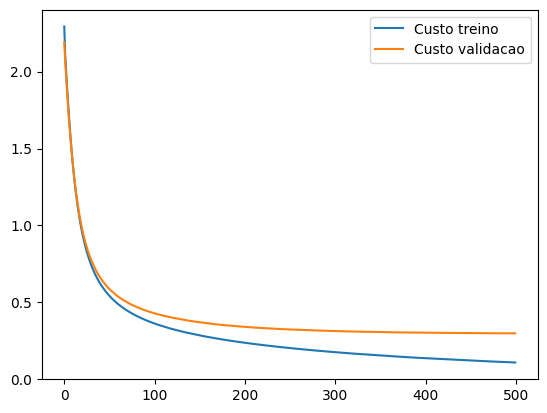

In [26]:
########################## COMPLETE O CÓDIGO AQUI  ########################
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']

df.plot()
plt.show()

##########################################################################

**Calculando o desempenho nos dados de teste**

Vamos testar o modelo nos dados de teste.

In [27]:
import sklearn as skl
import sklearn.metrics

def predicao(model, X_test, Y_test, num_labels):
    """
    Retorna as classes preditas e a acurácia
    """

    # variaveis que precisam ser calculadas
    predClass = None
    acuracia = 0.0

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # (1) converta os dados de teste para o formato binário
    # (2) use o método evaluate para obter a acurácia
    # (3) use o método predict para obter a probabilidade de cada classe
    # (4) use o método argmax do numpy para obter o índice da classe com maior probabilidade
    # (5) converta os índices nas classes do problema. Lembre-se que as classes variam de 1 até 10
    #

    Y_testBin = converteBinario(Y_test, num_labels)

    test_results = model.evaluate(X_test, Y_testBin, verbose=0)

    acuracia = test_results[1]
    pred = model.predict(X_test)
    predClass = np.argmax(pred, axis =1)


    ##########################################################################

    return predClass, acuracia


# obtem as classes
predClass, acuracia = predicao(model, X_test, Y_test, num_labels)

print('Acuracia: %1.3f' %acuracia)


# obtem as medidas de desempenho
resultados = skl.metrics.classification_report(Y_test, predClass)

print(resultados)

32/32 [==============================] - 0s 1ms/step
Acuracia: 0.909
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        98
           1       0.96      0.95      0.95        93
           2       0.90      0.91      0.91       102
           3       0.88      0.88      0.88        92
           4       0.90      0.97      0.93       101
           5       0.88      0.88      0.88       106
           6       0.93      0.94      0.94       104
           7       0.92      0.86      0.89       102
           8       0.86      0.87      0.87        94
           9       0.89      0.86      0.88       108

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



---
## Treinando outra rede neural

Modifique a rede neural anterior acrescentando regularização (L2 e *dropout*), camadas e modificando a quantidade de neurônios em cada camada, a função de ativação e o método de otimização. Isso irá ajudá-lo a entender melhor o funcionamento das redes neurais multicamadas.

In [30]:
# variável que deverá recer o modelo
model = None

########################## COMPLETE O CÓDIGO AQUI  ########################
#
# (1) importe o método tensorflow.keras.models.Sequential
# (2) importe o método tensorflow.keras.models.Dense
# (3) importe o método tensorflow.keras.models.Input
# (3) inicialize a camada de entrada usando o método Input
# (4) crie duas camadas intermediárias usando o método Dense.
#     Use ativação relu. Defina a regulação com o método tf.keras.regularizers.L2
#     Adicione Dropout de 20% em cada camada intermediária.
# (5) crie uma camada de saída com ativação sigmoid usando o método Dense
#     Use ativação softmax
# (6) inicialize o método de otimização que será usado para otimizar os
#     custos. Use o Adam: tf.keras.optimizers.Adam e defina o learning_rate
# (7) Configure o treinamento por meio do método compile.
#     Para o parâmetro loss, use o categorical_crossentropy.
#     Para o parâmetro optimizer, use o método de otimização do passo anterior.
#     Para o parâmetro metrics, use acurácia
# (8) Inicie o treinamento com o método fit. Defina o parâmetro epochs com valor
#     500. Use o parâmetro validation_split com valor 0.2. Defina o parâmetro
#     batch_size para 500. Use o parâmetro verbose como 0 para não ficar imprimindo
#     cada época na tela

input_shape = (input_layer_size,)

regularization = tf.keras.regularizers.L2(0.1)

model = tf.keras.Sequential()

#camada de entrada
model.add(tf.keras.Input(shape = input_shape))

#camada intermediaria
model.add(tf.keras.layers.Dense(units = hidden_layer_size,
                                activation = 'relu',
                                activity_regularizer=regularization))

model.add(tf.keras.layers.Dropout(0.1))

#camada intermediaria
model.add(tf.keras.layers.Dense(units = hidden_layer_size,
                                activation = 'relu',
                                activity_regularizer=regularization))

model.add(tf.keras.layers.Dropout(0.1))
#camada saida
model.add(tf.keras.layers.Dense(units = num_labels,
                                activation = 'softmax'))

#optmizer = tf.keras.optimizers.SGD(learning_rate=0.1)
optmizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(loss = 'categorical_crossentropy', optimizer=optmizer, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, Y_trainBin, epochs=500, batch_size=500, validation_split=0.2, verbose=0)

##########################################################################

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 25)                19625     
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_14 (Dense)            (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                260       
                                                                 
Total params: 20,535
Trainable params: 20,535
Non-trainable params: 0
_________________________________________________________________
None


Vamos plotar a evolução do erro.

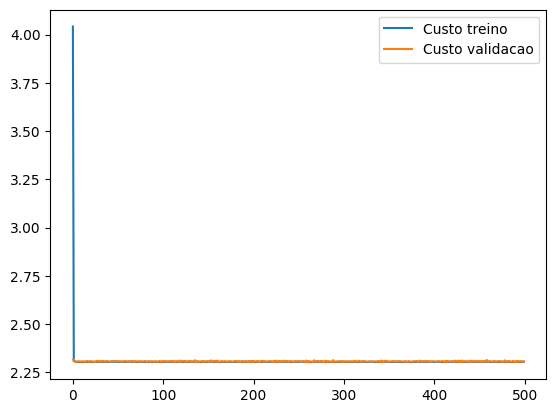

In [31]:
########################## COMPLETE O CÓDIGO AQUI  ########################

df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']

df.plot()
plt.show()


##########################################################################

**Calculando o desempenho nos dados de teste**

Vamos testar o modelo nos dados de teste.

In [32]:
########################## COMPLETE O CÓDIGO AQUI  ########################

# obtem as classes
predClass, acuracia = predicao(model, X_test, Y_test, num_labels)

print('Acuracia: %1.3f' %acuracia)


# obtem as medidas de desempenho
resultados = skl.metrics.classification_report(Y_test, predClass)

print(resultados)


##########################################################################

32/32 [==============================] - 0s 1ms/step
Acuracia: 0.092
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.00      0.00      0.00        93
           2       0.00      0.00      0.00       102
           3       0.09      1.00      0.17        92
           4       0.00      0.00      0.00       101
           5       0.00      0.00      0.00       106
           6       0.00      0.00      0.00       104
           7       0.00      0.00      0.00       102
           8       0.00      0.00      0.00        94
           9       0.00      0.00      0.00       108

    accuracy                           0.09      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.09      0.02      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
